# Beamline 8.3.2 Reconstruction

In [39]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import sys
import os
import multiprocessing as mp
os.environ['NUMEXPR_MAX_THREADS'] = str(mp.cpu_count()) # to avoid numexpr warning
import time
import numexpr
import numpy as np
from skimage import transform, filters, io
import tomopy
import svmbir
import dxchange
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed, IntSlider, FloatSlider, FloatRangeSlider
import ALS_recon_helper as als
use_gpu = als.check_for_gpu()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Nvidia GPU detected, will use to reconstruct!


### Choose Data

In [2]:
dataDir = "//global/cfs/cdirs/als/users/dperl/petiole_data" # where is the raw data
filelist = als.get_directory_filelist(dataDir)

24: misaligned_data
23: aligned_data
22: 20211222_195929_Petiole2_Scan6.h5
21: 20211222_194249_Petiole2_Scan5.h5
20: 20211222_192348_Petiole3_Hydrated_Excised.h5
19: 20211222_185821_Petiole2_Scan4.h5
18: 20211222_184039_Petiole4_Hydrated_Excised_Scan.h5
17: 20211222_175058_Petiole3_Scan3.h5
16: 20211222_173253_Petiole2_Scan3.h5
15: 20211222_165119_Petiole4_Scan2.h5
14: 20211222_163153_Petiole5_Scan2_down_2x2x2x.h5
13: 20211222_163153_Petiole5_Scan2.h5
12: 20211222_160403_Liz_N2B_4X.h5
11: 20211222_154721_Liz_N2A_4X.h5
10: 20211222_152037_Liz_N1B_4X.h5
9: 20211222_150453_Liz_N1A_4X.h5
8: 20211222_145043_Liz_Adult_2_14X.h5
7: 20211222_143318_Liz_Adult_1_14X.h5
6: 20211222_140955_Liz_Adult_1_10X.h5
5: 20211222_134208_petiole2_scan2.h5
4: 20211222_132508_petiole5.h5
3: 20211222_125057_petiole4.h5
2: 20211222_122032_petiole3_scan2.h5
1: 20211222_113313_petiole3.h5
0: 20211222_104840_petiole_test2.h5


##### Make selection from list

In [3]:
filename = filelist[1]
path = os.path.join(dataDir, filename)
metadata = als.read_metadata(path)

20211222_113313_petiole3.h5:
numslices: 2160, rays: 2560, numangles: 1313
angularrange: 180.0, \pxsize: 0.6499999999999999 um, distance: 170.079239 mm. energy: 22.999463034 keV


### Find Center of Rotation (COR)
##### Try many CORs to find best one. With mismatched COR, arc/shadow artifacts appear in image. Adjust COR to minimize

Projection data shape: (1312, 1, 640)
Inital COR found: 36.0 pixels (at full resolution)
Finisehd 40 reconstructions, size: (1, 640, 640)


interactive(children=(IntSlider(value=20, description='COR', layout=Layout(width='50%'), max=39, readout=False…

interactive(children=(FloatRangeSlider(value=(-0.0008293616067385301, 0.0010063685721252117), description='Col…


This took:
CPU times: user 6.52 s, sys: 10.2 s, total: 16.7 s
Wall time: 6.17 s


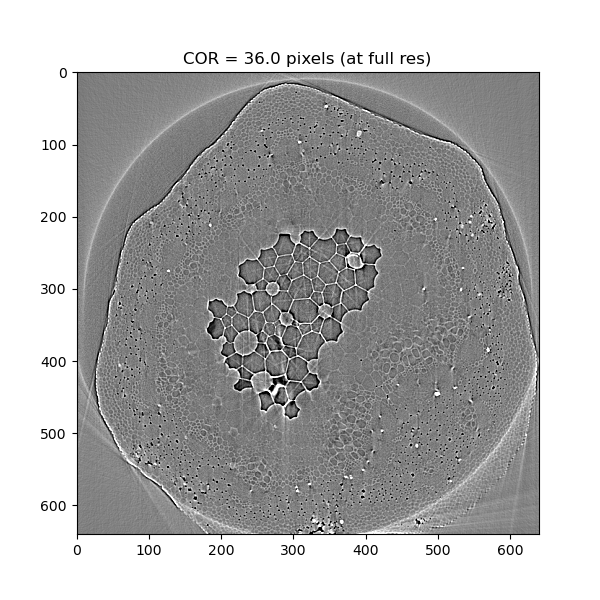

In [62]:
%%time
########## parameters ##########
angles_ind = slice(0,-1,1) # get all angles (explicitly, can also use None)
# angles_ind = slice(0,-1,4) # get every 4th angle
# slices_ind = slice(0,1,1) # get first slice
slices_ind = slice(metadata['numslices']//2,metadata['numslices']//2+1,1) # get only middle slice
downsample_factor = 4 # downsample projections for speed (in both slice and ray dimensions). None is no downsample
cor_search_range = 10 # pixels (at full res pixels)
cor_search_step = 0.5 # pixels (at full res pixels)
fc = None # FBP LP filter cutoff: 0-to-1. None is no filtering
########## dont touch code below ##########
tomo, angles = als.read_data(path, proj=angles_ind, sino=slices_ind, downsample_factor=downsample_factor)
print(f"Projection data shape: {tomo.shape}")
cor_init= als.auto_find_cor(path)
print(f"Inital COR found: {cor_init} pixels (at full resolution)")
cors = np.arange(cor_init-cor_search_range,cor_init+cor_search_range,cor_search_step) # narrow COR range
recons = [als.astra_fbp_recon(tomo,angles,center=cor/downsample_factor,fc=fc,gpu=use_gpu) for cor in cors]
print(f"Finisehd {len(recons)} reconstructions, size: {recons[0].shape}")
img, axs, clim_slider = als.plot_recon(recons[0],fignum=1,figsize=6)
cor_slider = widgets.interactive(als.set_cor, i=IntSlider(description='COR', layout=widgets.Layout(width='50%'),
                                                          min=0, max=len(cors)-1, step=1, value=len(cors)//2, readout=False),
                                 img=fixed(img), axs=fixed(axs), recons=fixed(recons), cors=fixed(cors))
display(cor_slider)
display(clim_slider)
print()
print('This took:')

##### Check COR by manually aligning 0 and 180 degree projections
###### not doing anything with y shift at the moment

Output()

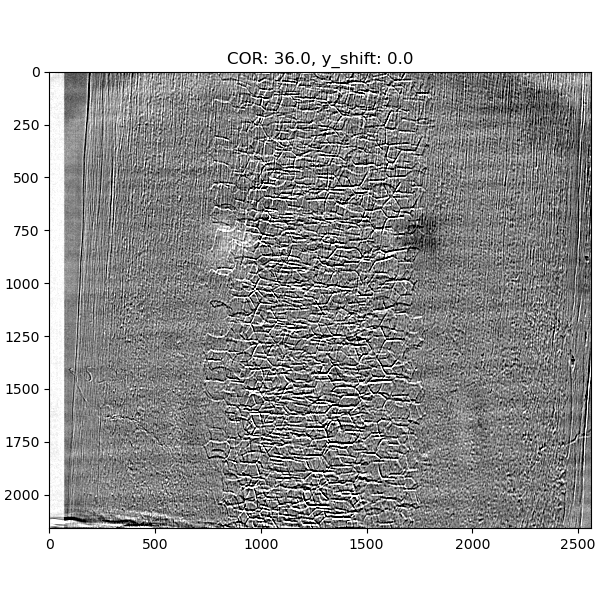

In [5]:
COR = cors[cor_slider.children[0].value]
tomo, _ = als.read_data(path, proj=slice(0,None,metadata['numangles']-1), downsample_factor=None)
first_proj, last_proj_flipped = tomo[0], np.fliplr(tomo[-1])
axs, img, ui, proj_0_180_sliders = als.plot_0_and_180_proj_diff(first_proj,last_proj_flipped,init_cor=-2*COR,fignum=1,figsize=6)
display(ui,proj_0_180_sliders)

clim_init### Reconstuct 2D slice
##### Reconstruct 2D slice with FBP at full resolution with best COR 
##### At full resolution (1313 ang x 2560 rays), takes ~2 sec/slice with GPU, ~30 sec/slice on CPU. Downsampling by 2x reduces time by ~4x (plus loading time)
###### Set 'args' to remove artifacts with additional sinogram preprocessing -- preprocessing takes extra time, reduces resolution, and sometimes can introduce artifacts too, so don't use unless needed

Projection data shape: (1313, 1, 2560)
Finisehd reconstruction, size: (1, 2560, 2560)


interactive(children=(FloatRangeSlider(value=(-0.0013444679568056018, 0.0013955944695044303), description='Col…


This took:
CPU times: user 5.33 s, sys: 11 s, total: 16.3 s
Wall time: 4.46 s


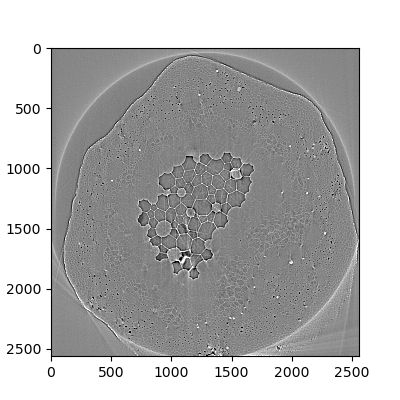

In [65]:
%%time
########## parameters ##########
angles_ind = None # get all angles
slices_ind = slice(metadata['numslices']//2,metadata['numslices']//2+1,1) # get only middle slice
downsample_factor = 1 # downsample projections for speed (in both slice and ray dimensions)
fc = 0.5 # FBP LP filter cutoff: 0-to-1. None is no filtering
COR = 36.5 # from above
# args = None # don't do any preprocessing
args = { # preprocessing parameters
    'minimum_transmission': None, # threshold for pre-log, normalized sinogram. None turns off
    # for sarepy ring removal
    'snr': 3,  # Sensitivity of stripe detection method. Smaller is more sensitive. Recommended values: 1.1 -> 3.0.
    'la_size': 1, # Window size of the median filter to remove large stripes. Larger is stronger but takes longer. Choose odd value, set to 1 to turn off.
    'sm_size': 11, # Window size of the median filter to remove small stripes. Same advice as above
}
########## dont touch code below ##########
tomo, angles = als.read_data(path, proj=angles_ind, sino=slices_ind, downsample_factor=downsample_factor, args=args)
print(f"Projection data shape: {tomo.shape}")
fbp_recon = als.astra_fbp_recon(tomo,angles,center=COR/downsample_factor,fc=fc,gpu=use_gpu)
print(f"Finisehd reconstruction, size: {fbp_recon.shape}")
img, axs, clim_slider = als.plot_recon(fbp_recon,fignum=3,figsize=4)
display(clim_slider)
print('')
print('This took:')

### Reconstruct 3D volume
##### At full resolution (1313 ang x 2560 rays), 100 slices takes ~ 30 sec with 1 GPU
##### For viewing

Projection data shape: (1313, 100, 2560)
Finished reconstruction, size: (100, 2560, 2560)


interactive(children=(IntSlider(value=50, description='Slice', layout=Layout(width='50%'), max=99), Output()),…

interactive(children=(FloatRangeSlider(value=(-0.0013773934915661812, 0.0014386430848389864), description='Col…


This took:
CPU times: user 1min 12s, sys: 16.6 s, total: 1min 28s
Wall time: 56.9 s


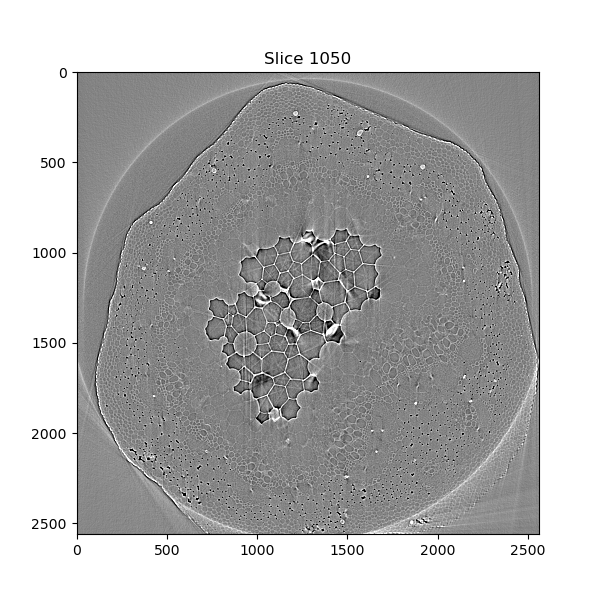

In [71]:
%%time
########## parameters (assumes others have ben set above) ##########
slices_ind = slice(1000,1100,1)
########## dont touch code below ##########
tomo, angles = als.read_data(path, sino=slices_ind, downsample_factor=downsample_factor, args=args)
print(f"Projection data shape: {tomo.shape}")
recon = als.astra_fbp_recon(tomo,angles,center=COR/downsample_factor,fc=fc,gpu=use_gpu)
print(f"Finished reconstruction, size: {recon.shape}")
img, axs, clim_slider = als.plot_recon(recon,fignum=5,figsize=6,clims=[np.percentile(recon,1),np.percentile(recon,99)])
slice_slider = widgets.interactive(als.set_slice, img=fixed(img), axs=fixed(axs), recon=fixed(recon),
                                   slices=fixed(np.arange(slices_ind.start,slices_ind.stop)),
                                   slice_num=IntSlider(description='Slice', layout=widgets.Layout(width='50%'),
                                                        min=0, max=len(recon)-1, step=1, value=len(recon)//2))
display(slice_slider)
display(clim_slider)
print('')
print('This took:')

##### For saving

In [35]:
########## parameters (assumes others have ben set above) ##########
outputDir = "/pscratch/sd/d/dperl/tomo_data/Petiole" # somewhere you can write lots of data
subdirectoryname = 'petiole_reconstructions_examples' # new folder where reconstuctions will be saved
start = 0
stop = 500
nchunk = 100
########## dont touch code below ##########
saveDir = os.path.join(outputDir,subdirectoryname,os.path.splitext(filename)[0])
if not os.path.exists(saveDir): os.makedirs(saveDir)
saveName = os.path.join(saveDir,"img")
for i in range(np.ceil((stop-start)/nchunk).astype(int)):
    start_iter = start+i*nchunk
    stop_iter = np.minimum(start_iter+nchunk,stop)
    tomo, angles = als.read_data(path, sino=slice(start_iter,stop_iter,1), downsample_factor=downsample_factor, args=args)
    print(f"Starting recon of slices {start_iter}-{stop_iter}...",end=' ')
    tic = time.time()
    recon = als.astra_fbp_recon(tomo,angles,center=COR/downsample_factor,fc=fc,gpu=use_gpu)
    print(f"Finished: took {time.time()-tic} sec. Saving files...")
    dxchange.write_tiff_stack(recon, fname=saveName, start=start_iter)

Starting recon of slices 0-100... Finished: took 26.89082145690918 sec. Saving files...
Starting recon of slices 100-200... Finished: took 25.70534062385559 sec. Saving files...
Starting recon of slices 200-300... Finished: took 25.925835847854614 sec. Saving files...
Starting recon of slices 300-400... Finished: took 27.473727464675903 sec. Saving files...
Starting recon of slices 400-500... Finished: took 27.372495412826538 sec. Saving files...


### SVMBIR (for better image quality)
##### Reconstruct 2D slice with SVMBIR at full resolution with best COR.
##### At full resolution (1313 ang x 2560 rays), takes ~2-4 min/slice with all 128 exclusive node threads (uses CPU only). Downsampling by 2x reduces time by ~4x (plus loading time)

In [ ]:
%%time
########## parameters (assumes others have ben set above) ##########
# Default settings are typically good, don't need to change unless 
p = 1.2 # smoothing parameter for large differences (ie contrasting pixels). Between 1 and 2 (1 = total variation regularization, 2 = Tikhonov regularization)
q = 2 # smoothing parameter for small differences (ie. similar pixels). Between p and 2
T = 0.1 # transition value from q to p (in pixel grayscale difference). Must be > 0
sharpness = 0 # stregth of smoothing -- lower is more smooth. +1 change is equivalent to +6 dB snr
snr_db = 40.0 # strength of smoothing -- lower is more smooth. +6 dB is equivalent to +1 sharpness
########## dont touch code below ##########
tomo, angles = als.read_data(path, proj=angles_ind, sino=slices_ind, downsample_factor=downsample_factor)
tomo = als.shift_projections(tomo,COR/downsample_factor) # must manually shift COR. Shifting SVMBIR projector requires recomputing system matrix
svmbir_recon = svmbir.recon(tomo,angles,
                          center_offset=0.0, # MUST BE ZERO TO AVOID VERY LONG COMPUTATION OF SYSTEM MATRIX
                          init_image=fbp_recon.copy(), # init with fbp for faster convergence. .copy() is important to not overwite fbp_recon                     
                          T=T, q=q, p=p, sharpness=sharpness, snr_db=snr_db,
                          positivity=False, # must be False due to phase contrast in ALS data
                          num_threads=128,  
                          # max_iterations=20,
                          svmbir_lib_path=als.get_svmbir_cache_dir(), # must have access to this directory
                          verbose=1) # 0, 1 or 2
svmbir_recon = svmbir_recon.transpose(0,2,1) # to match tomopy format
print(f"Finisehd reconstruction, size: {fbp_recon.shape}")
print('')
print('This took:')

In [ ]:
# plotting in separate cell, since svmbir takes awhile 
als.plot_recon_comparison(fbp_recon,svmbir_recon,titles=['FBP','SVMBIR'],fignum=6,figsize=4)

### Ready to submit a bigger job to the NERSC Cluster?

In [ ]:
# Understand Lipi's example (or maybe easier to have users ssh into NERSC and point them to code?)
# Write mpi4py for slice-by-slice svmbir 

### Want to see how the jobs are doing? Copy and paste the following into a terminal (logged into`perlmutter-p1.nersc.gov`): 

`squeue -u <NERSC USERNAME>`